<a href="https://colab.research.google.com/github/theJimJack/mod_4_project/blob/master/working_notebook_prime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
### LOAD DATA FROM GOOGLE DRIVE

# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
!unzip pictures2.zip

Archive:  pictures2.zip
replace pictures/0205762611.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:

folder_id='17ZHfezur8CY9XK4lfZ2b3o6jzfn3JsCo'
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
print(file_list)


downloaded = drive.CreateFile({'id': folder_id})
downloaded.GetContentFile(downloaded['title'])

[]


In [0]:
import pandas as pd
import numpy as np
import cleaner

In [5]:
## Create dataframe
df = pd.read_csv('data.csv',encoding="latin")
# df.columns = ['img_idx','img_file','img_link','title','author','cat_id','category']
# other = [3,8,10,11,14,15,18, 20,25,27, 28,29, 30,31]
# df = df.loc[~df['cat_id'].isin(other)]
df = df.drop("Unnamed: 0",axis=1)
print(df.shape)
df.head()

(36000, 8)


,index,img_idx,img_file,img_link,title,author,cat_id,category
0,56649,865717842,0865717842.jpg,http://ecx.images-amazon.com/images/I/51DqEOpN...,Real Goods Solar Living Sourcebook: Your Compl...,John Schaeffer,0,Arts & Photography
1,56533,415689317,0415689317.jpg,http://ecx.images-amazon.com/images/I/414gx4Qv...,Translucent Building Skins: Material Innovatio...,Scott Murray,0,Arts & Photography
2,56250,1565548310,1565548310.jpg,http://ecx.images-amazon.com/images/I/4173MVBP...,New Orleans Architecture: Faubourg TremÃÂ© an...,Roulhac Toledano,0,Arts & Photography
3,61325,3867878811,3867878811.jpg,http://ecx.images-amazon.com/images/I/51-JWrCa...,Sixty Nine: Joyful Gay Sex - Featuring Cockyboys,NaN,0,Arts & Photography
4,61280,133856887,0133856887.jpg,http://ecx.images-amazon.com/images/I/51tyyOiL...,"The Digital Photography Book, Part 5: Photo Re...",Scott Kelby,0,Arts & Photography


In [6]:
#What are our categories?
df.category.unique()

array(['Arts & Photography', 'Biographies & Memoirs', 'Business & Money',
       "Children's Books", 'Christian Books & Bibles',
       'Comics & Graphic Novels', 'Computers & Technology',
       'Cookbooks, Food & Wine', 'History', 'Humor & Entertainment',
       'Medical Books', 'Mystery, Thriller & Suspense',
       'Politics & Social Sciences', 'Religion & Spirituality', 'Romance',
       'Science & Math', 'Science Fiction & Fantasy', 'Sports & Outdoors'],
      dtype=object)

In [0]:
#given a class sample size, downsample classes that are smaller and then upsample classes that are bigger.
 sample_size = 1000

from sklearn.utils import resample

resampled_df_list = []
for category, group in df.groupby('category'):
  replace = len(group) < sample_size
  df_group_resampled = resample(group, replace=replace, n_samples=sample_size, random_state=123)
  resampled_df_list.append(df_group_resampled)
    
df_resampled = pd.concat(resampled_df_list)

#refer to resampled dataset from now on
df=df_resampled

In [8]:
#verifying things were properly resampled
print('There are ', len(df_resampled.groupby('img_file').groups), ' unique image files in our resampled data')

#number of categories
print('There are ', len(df_resampled.groupby('category').groups), ' categories')

correct_size = True
for category, group in df_resampled.groupby('category'):
    if len(group) != sample_size:
        correct_size = False
    
print('Categories have the correct sample size: ', correct_size)

There are  17785  unique image files in our resampled data
There are  18  categories
Categories have the correct sample size:  True


In [0]:
#test train split the dataframe
from sklearn.model_selection import train_test_split
#Notice that we don't drop target from x_train, since we have to feed a dataframe with target
# to train_generator

target = df['category']
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2)


#have to reset index of x_test so that can use image_data_generator on it ??
x_train = x_train.reset_index()
y_train = y_train.reset_index()
x_test = x_test.reset_index()
y_test = y_test.reset_index()

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

directory = 'pictures/'
batch_size = 256
train_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(x_train, directory, x_col='img_file', y_col='category', has_ext=True, target_size=(299, 299), color_mode='rgb', classes=None, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='jpeg', subset=None, interpolation='nearest')
#train_images, train_labels = next(train_generator)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(x_test, directory, x_col='img_file', y_col='category', has_ext=True, target_size=(299, 299), color_mode='rgb', classes=None, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='jpeg', subset=None, interpolation='nearest')


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:2059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df[x_col] = self.df[x_col].astype(str)


Found 13345 images belonging to 18 classes.
Found 3350 images belonging to 18 classes.


In [0]:
num_classes = len(df.category.unique())

In [0]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [0]:
from keras.applications import inception_v3

#initialise inception base model
base_model=inception_v3.InceptionV3(weights='imagenet',include_top=False)

x = base_model.output

#add our architecture

# add pooling layer
x = GlobalAveragePooling2D()(x)
# add fully-connected layer with 1024 neurons 
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [0]:
# turn off transfer layer training
num_transfer_layers = len(base_model.layers)

for layer in model.layers[:num_transfer_layers]:
    layer.trainable = False

In [15]:
#number of epochs corresponds to one iteration through the entire dataset
EPOCHS = 5

#just picked a random optimizer and loss function
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit_generator(train_generator, validation_data=test_generator, 
                    steps_per_epoch=len(x_train)//batch_size, 
                    validation_steps=len(x_test)//batch_size, use_multiprocessing=True,
                    max_queue_size=12, epochs=EPOCHS)


Epoch 1/5
56/56 [==============================] - 180s 3s/step - loss: 2.6446 - acc: 0.1961 - val_loss: 3.4757 - val_acc: 0.0451
Epoch 2/5
56/56 [==============================] - 155s 3s/step - loss: 2.2730 - acc: 0.3018 - val_loss: 4.0766 - val_acc: 0.0445
Epoch 3/5
56/56 [==============================] - 158s 3s/step - loss: 2.1710 - acc: 0.3366 - val_loss: 3.8667 - val_acc: 0.0719
Epoch 4/5
56/56 [==============================] - 160s 3s/step - loss: 2.0993 - acc: 0.3547 - val_loss: 4.2320 - val_acc: 0.0424
Epoch 5/5
56/56 [==============================] - 156s 3s/step - loss: 2.0151 - acc: 0.3777 - val_loss: 4.4687 - val_acc: 0.0543


In [0]:
#TODO: get live training vs validation loss graph so we can visualise overfitting... and speed this up somehow! 
#TODO: tune hyperparameters to optimise for ... f1 score? probably.
#TODO: figure out how to actually use the model for prediction

In [0]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


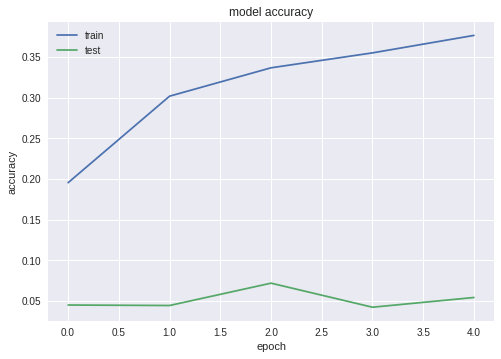

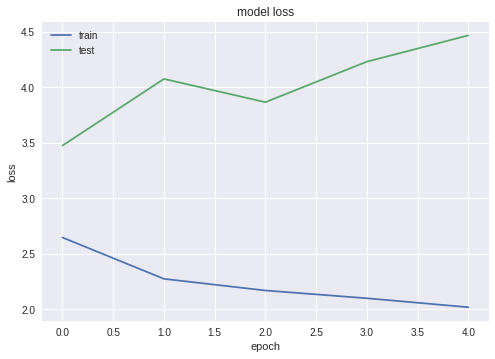

In [19]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()